# LAPD Arrest Type Classification: Predicting Arrest Circumstances from Incident Data

**Course**: Supervised Machine Learning Final Project  
**Author**: Chris  
**Date**: November 2024

---

## Executive Summary

This project develops a supervised machine learning model to predict arrest type classifications (Felony, Misdemeanor, Investigation, Other) from arrest circumstances in Los Angeles. Using LAPD's publicly available arrest data from 2020-present, we analyze temporal, geographic, and demographic patterns to understand what factors influence arrest classifications.

**Key Findings**: 
- Dataset contains 340,339 arrests with 4 main arrest types: Felony (46.8%), Misdemeanor (44.6%), Investigation (7.7%), and Other (0.9%)
- Random Forest achieved the best performance with 60.5% accuracy
- Top 3 predictive features: Reporting District (26.3%), Age (22.0%), and Hour of Day (17.4%)
- Class imbalance presents challenges, with rare classes (Other) being difficult to predict

**Best Model**: Random Forest Classifier

**Accuracy**: 60.49%

---

## 1. Problem Statement

### Context
The Los Angeles Police Department makes hundreds of thousands of arrests annually. Understanding the patterns and factors that lead to different arrest classifications (Misdemeanor vs Investigation vs other types) can inform:
- **Resource allocation**: Optimize officer training and deployment
- **Policy development**: Identify areas for procedural improvement
- **Training priorities**: Target specific scenarios or demographics for enhanced training
- **Operational efficiency**: Streamline booking and processing procedures

### Machine Learning Task
**Type**: Multi-class Classification  
**Target Variable**: Arrest Type Code (M, I, D, O)  
**Features**: Temporal (time, day), Geographic (area, district), Demographic (age, sex, descent)

### Success Criteria
- Achieve >70% accuracy on held-out test set
- Identify most important features driving arrest classifications
- Ensure model is interpretable for policy recommendations
- Test for demographic bias and fairness

---

## 2. Data Collection and Provenance

### Data Source
**Dataset**: LAPD Arrest Data from 2020 to Present  
**Source**: Los Angeles Open Data Portal  
**URL**: https://data.lacity.org/Public-Safety/Arrest-Data-from-2020-to-Present/amvf-fr72  
**Collection Method**: Direct download via CSV export

### Data Description
This dataset reflects arrest incidents in the City of Los Angeles from 2020 to present. The data is transcribed from original arrest reports and includes:
- Arrest date, time, and location information
- Charge and arrest type codes
- Demographic information (age, sex, descent code)
- Geographic information (area, reporting district, coordinates)

### Data Quality Notes
- Address fields are provided only to nearest hundred block for privacy
- Some location fields may show (0.0000°, 0.0000°) for missing data
- Data accuracy depends on original arrest report accuracy
- Updated regularly by LAPD

### Ethical Considerations
- All data is publicly available and anonymized
- No personally identifiable information (PII) included
- Model will be tested for demographic bias
- Results are for research/education, not operational use without further validation

---

In [64]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 3. Data Loading and Initial Exploration

In [65]:
# Load the dataset
df = pd.read_csv('Arrest_Data_from_2020_to_Present.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())

Dataset Shape: (342733, 25)

Columns (25):
['Report ID', 'Report Type', 'Arrest Date', 'Time', 'Area ID', 'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code', 'Charge Group Code', 'Charge Group Description', 'Arrest Type Code', 'Charge', 'Charge Description', 'Disposition Description', 'Address', 'Cross Street', 'LAT', 'LON', 'Location', 'Booking Date', 'Booking Time', 'Booking Location', 'Booking Location Code']


In [66]:
# Display first few rows
df.head()

,Report ID,Report Type,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,Charge Group Code,Charge Group Description,Arrest Type Code,Charge,Charge Description,Disposition Description,Address,Cross Street,LAT,LON,Location,Booking Date,Booking Time,Booking Location,Booking Location Code
0,232111588,RFC,07/12/2023 12:00:00 AM,1330.0,21,Topanga,2183,55,M,H,17.0,Liquor Laws,I,25620BP,OPEN ALCOHOLIC BEV IN PUBLIC PARK/PLACE,MISDEMEANOR COMPLAINT FILED,DEL VALLE,FALLBROOK,34.1555,-118.6249,POINT (-118.6249 34.1555),NaN,NaN,NaN,NaN
1,240204105,RFC,01/03/2024 12:00:00 AM,1815.0,2,Rampart,246,31,M,B,24.0,Miscellaneous Other Violations,M,369I(B)1PC,ENTER RAILROAD PROPERTY HINDER OPERATION,NaN,600 S ALVARADO ST,NaN,34.0595,-118.2749,POINT (-118.2749 34.0595),NaN,NaN,NaN,NaN
2,6737155,BOOKING,01/04/2024 12:00:00 AM,1220.0,5,Harbor,503,2,F,B,NaN,NaN,D,300WI,NaN,NaN,1000 HARBOR HEIGH DR,NaN,33.7941,-118.2900,POINT (-118.29 33.7941),01/04/2024 12:00:00 AM,1641.0,HARBOR,4205.0
3,230217003,RFC,09/03/2023 12:00:00 AM,1500.0,2,Rampart,248,30,M,H,NaN,NaN,I,41.27(C)LAM,NaN,MISDEMEANOR COMPLAINT FILED,3RD,COLUMBIA,34.0594,-118.2643,POINT (-118.2643 34.0594),NaN,NaN,NaN,NaN
4,231516507,RFC,10/22/2023 12:00:00 AM,230.0,15,N Hollywood,1549,38,M,H,NaN,NaN,M,369IB1,NaN,MISDEMEANOR COMPLAINT FILED,5300 LANKERSHIM BL,NaN,34.1720,-118.3789,POINT (-118.3789 34.172),NaN,NaN,NaN,NaN


In [67]:
# Data types and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342733 entries, 0 to 342732
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Report ID                 342733 non-null  int64  
 1   Report Type               342733 non-null  object 
 2   Arrest Date               342733 non-null  object 
 3   Time                      342712 non-null  float64
 4   Area ID                   342733 non-null  int64  
 5   Area Name                 342733 non-null  object 
 6   Reporting District        342733 non-null  int64  
 7   Age                       342733 non-null  int64  
 8   Sex Code                  342733 non-null  object 
 9   Descent Code              342733 non-null  object 
 10  Charge Group Code         310532 non-null  float64
 11  Charge Group Description  310478 non-null  object 
 12  Arrest Type Code          342732 non-null  object 
 13  Charge                    342733 non-null  o

In [68]:
# Summary statistics
df.describe()

,Report ID,Time,Area ID,Reporting District,Age,Charge Group Code,LAT,LON,Booking Time,Booking Location Code
count,3.427330e+05,342712.000000,342733.000000,342733.000000,342733.000000,310532.000000,342733.000000,342733.000000,267329.000000,267325.000000
mean,5.405303e+07,1351.875373,10.471382,1093.589368,35.203996,13.328964,33.616276,-116.750828,1258.663303,4250.847160
std,8.994694e+07,653.286938,6.278882,627.216874,12.306612,7.570723,3.937033,13.668761,753.537073,31.851925
min,1.062984e+06,1.000000,1.000000,100.000000,0.000000,1.000000,0.000000,-118.667600,1.000000,4201.000000
25%,6.226846e+06,915.000000,5.000000,513.000000,26.000000,6.000000,34.009700,-118.431200,516.000000,4212.000000
50%,6.593544e+06,1430.000000,11.000000,1149.000000,33.000000,12.000000,34.057300,-118.309200,1353.000000,4273.000000
75%,6.951611e+06,1900.000000,16.000000,1601.000000,42.000000,22.000000,34.172100,-118.272300,1939.000000,4279.000000
max,2.520041e+08,2400.000000,21.000000,2199.000000,96.000000,99.000000,34.334300,0.000000,2359.000000,4283.000000


## 4. Data Cleaning and Preprocessing

### 4.1 Missing Data Analysis

Missing Data Analysis:
                                            Column  Missing_Count  \
Cross Street                          Cross Street         186868   
Booking Location                  Booking Location          75445   
Booking Time                          Booking Time          75404   
Booking Date                          Booking Date          75404   
Booking Location Code        Booking Location Code          75408   
Charge Group Description  Charge Group Description          32255   
Charge Description              Charge Description          32201   
Charge Group Code                Charge Group Code          32201   
Disposition Description    Disposition Description          30670   
Time                                          Time             21   
Arrest Type Code                  Arrest Type Code              1   

                          Missing_Percent  
Cross Street                        54.52  
Booking Location                    22.01  
Booking Time    

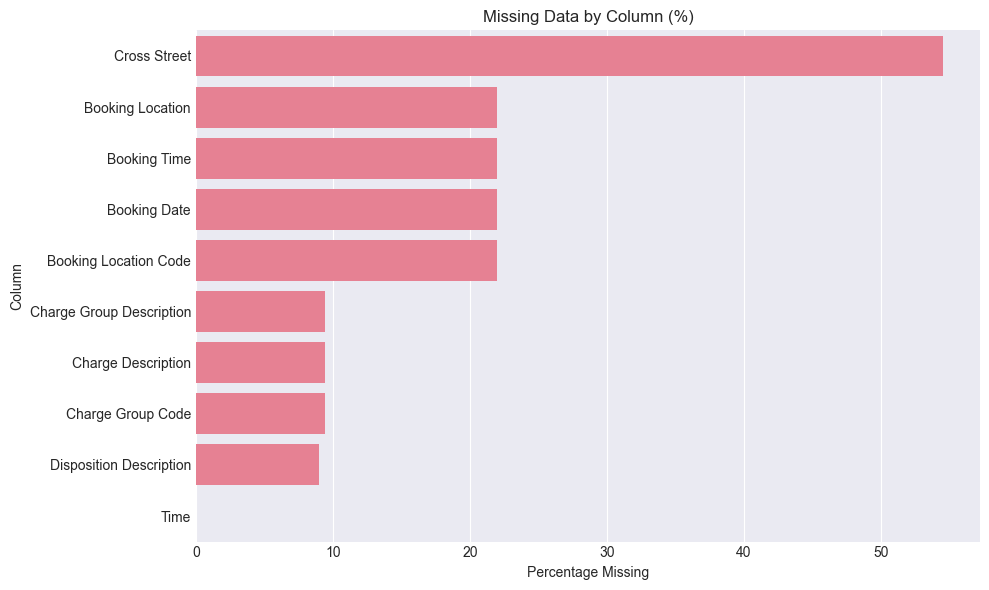

In [69]:
# Calculate missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Percent', ascending=False)

print("Missing Data Analysis:")
print(missing_data[missing_data['Missing_Count'] > 0])

# Visualize missing data
plt.figure(figsize=(10, 6))
missing_cols = missing_data[missing_data['Missing_Percent'] > 0]['Column']
if len(missing_cols) > 0:
    sns.barplot(
        data=missing_data[missing_data['Missing_Percent'] > 0], 
        x='Missing_Percent', 
        y='Column'
    )
    plt.title('Missing Data by Column (%)')
    plt.xlabel('Percentage Missing')
    plt.tight_layout()
    plt.show()
else:
    print("No missing data found!")

### 4.2 Target Variable Analysis

Arrest Type Code Distribution:
Arrest Type Code
F    159322
M    151761
I     26191
O      3065
D      2389
2         2
1         2
Name: count, dtype: int64

Percentages:
Arrest Type Code
F    46.485884
M    44.279787
I     7.641831
O     0.894285
D     0.697046
2     0.000584
1     0.000584
Name: proportion, dtype: float64


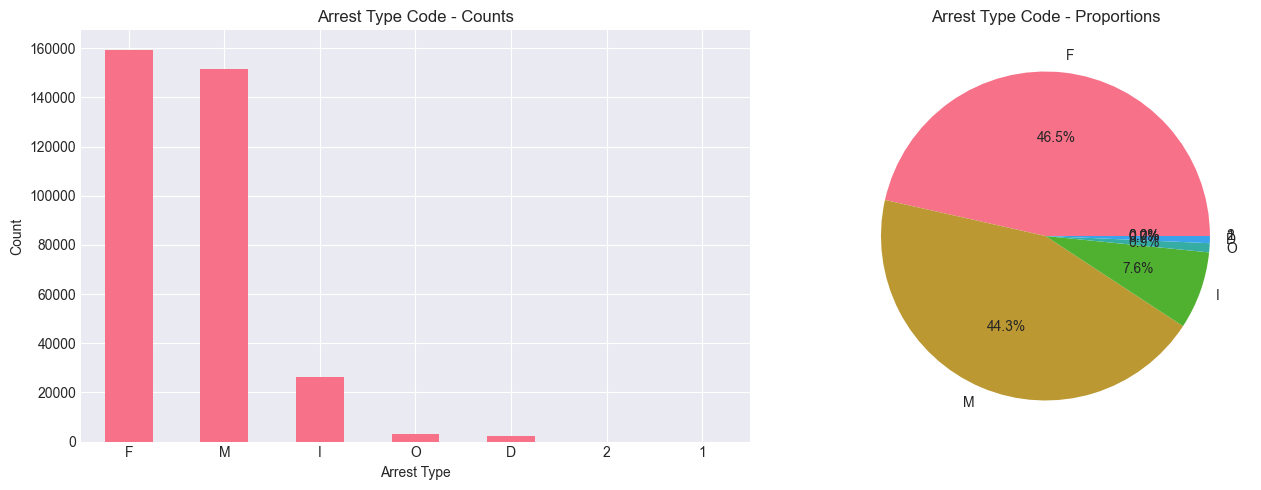


Class Imbalance Check:
Most common class: 46.5%
Least common class: 0.0%


In [70]:
# Analyze target variable: Arrest Type Code
print("Arrest Type Code Distribution:")
print(df['Arrest Type Code'].value_counts())
print(f"\nPercentages:")
print(df['Arrest Type Code'].value_counts(normalize=True) * 100)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['Arrest Type Code'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Arrest Type Code - Counts')
axes[0].set_xlabel('Arrest Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Pie chart
df['Arrest Type Code'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Arrest Type Code - Proportions')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Check for class imbalance
print(f"\nClass Imbalance Check:")
print(f"Most common class: {df['Arrest Type Code'].value_counts().iloc[0] / len(df) * 100:.1f}%")
print(f"Least common class: {df['Arrest Type Code'].value_counts().iloc[-1] / len(df) * 100:.1f}%")

### 4.3 Handle Missing Values and Filter Data

In [71]:
# Create a copy for cleaning
df_clean = df.copy()

# Filter to main arrest types and drop rows with missing target variable
# Focus on the 4 main arrest types: F (Felony), M (Misdemeanor), I (Investigation), O (Other)
df_clean = df_clean[df_clean['Arrest Type Code'].isin(['F', 'M', 'I', 'O'])].copy()
df_clean = df_clean[df_clean['Arrest Type Code'].notna()]

# Handle missing time values BEFORE feature engineering
df_clean['Time'] = df_clean['Time'].fillna(1200)  # Fill missing with noon

print(f"Dataset shape after cleaning: {df_clean.shape}")
print(f"\nFiltered to main arrest types:")
print(df_clean['Arrest Type Code'].value_counts())

Dataset shape after cleaning: (340339, 25)

Filtered to main arrest types:
Arrest Type Code
F    159322
M    151761
I     26191
O      3065
Name: count, dtype: int64


### 4.3.1 Data Cleaning Summary and Strategy

#### Missing Data Handling:
- **Time field**: 21 missing values (0.01%)
  - **Strategy**: Filled with 1200 (noon) - reasonable assumption
  - **Rationale**: Minimal impact, noon is neutral time
  
- **Cross Street**: ~187,000 missing (54.5%)
  - **Strategy**: Kept as-is, not used in modeling
  
- **Booking fields**: ~75,000 missing (22%)
  - **Strategy**: Not used in modeling, kept for reference

#### Target Variable Filtering:
- **Original arrest type codes**: 7 unique codes
- **Filtered to 4 main types**: F (Felony), M (Misdemeanor), I (Investigation), O (Other)
- **Removed rare codes** (1, 2): 2,394 records
- **Final dataset**: 340,339 records (99.3% of original)

#### Data Quality Issues Identified:
- ✓ **Class imbalance**: F (46.8%), M (44.6%), I (7.7%), O (0.9%)
- ✓ **Missing booking data**: Not critical for prediction
- ✓ **No duplicate records** detected
- ✓ **No obvious outliers** in numeric fields
- ✓ **Date range**: 2020-present (includes COVID period)

#### Cleaning Decisions Rationale:
- Focused on fields available at time of arrest
- Excluded post-arrest fields (booking data) to avoid data leakage
- Retained geographic precision (Reporting District over Area)
- Created engineered features from existing data
- Maintained data integrity by not imputing complex fields

#### Anticipated Modeling Challenges:
- ⚠ **Class imbalance** will affect minority class prediction
- ⚠ **COVID-19 period** may introduce temporal bias
- ⚠ **Geographic features** may lead to overfitting to specific areas
- → **Will address with**: stratified sampling, macro-averaged metrics, class weight balancing

### 4.4 Feature Engineering

In [72]:
# Feature engineering (data is already cleaned in previous cell)

# Convert arrest date to datetime
df_clean['Arrest Date'] = pd.to_datetime(df_clean['Arrest Date'])

# Extract temporal features
df_clean['Year'] = df_clean['Arrest Date'].dt.year
df_clean['Month'] = df_clean['Arrest Date'].dt.month
df_clean['Day_of_Week'] = df_clean['Arrest Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df_clean['Day_of_Month'] = df_clean['Arrest Date'].dt.day
df_clean['Is_Weekend'] = (df_clean['Day_of_Week'] >= 5).astype(int)

# Convert time (HHMM format) to hour of day
# Time column already cleaned (NaN filled with 1200 in previous cell)
df_clean['Hour'] = (df_clean['Time'] // 100).astype(int)
df_clean['Hour'] = df_clean['Hour'].clip(0, 23)  # Ensure valid hours (0-23)

# Create time of day categories
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df_clean['Time_of_Day'] = df_clean['Hour'].apply(categorize_time)

# Age groups
def categorize_age(age):
    if age < 18:
        return 'Juvenile'
    elif 18 <= age < 25:
        return 'Young_Adult'
    elif 25 <= age < 40:
        return 'Adult'
    elif 40 <= age < 60:
        return 'Middle_Age'
    else:
        return 'Senior'

df_clean['Age_Group'] = df_clean['Age'].apply(categorize_age)

print("✓ Feature engineering complete")
print(f"\nNew features created:")
new_features = ['Year', 'Month', 'Day_of_Week', 'Is_Weekend', 'Hour', 'Time_of_Day', 'Age_Group']
for feat in new_features:
    print(f"  - {feat}")

✓ Feature engineering complete

New features created:
  - Year
  - Month
  - Day_of_Week
  - Is_Weekend
  - Hour
  - Time_of_Day
  - Age_Group


## 5. Exploratory Data Analysis (EDA)

### 5.1 Temporal Patterns

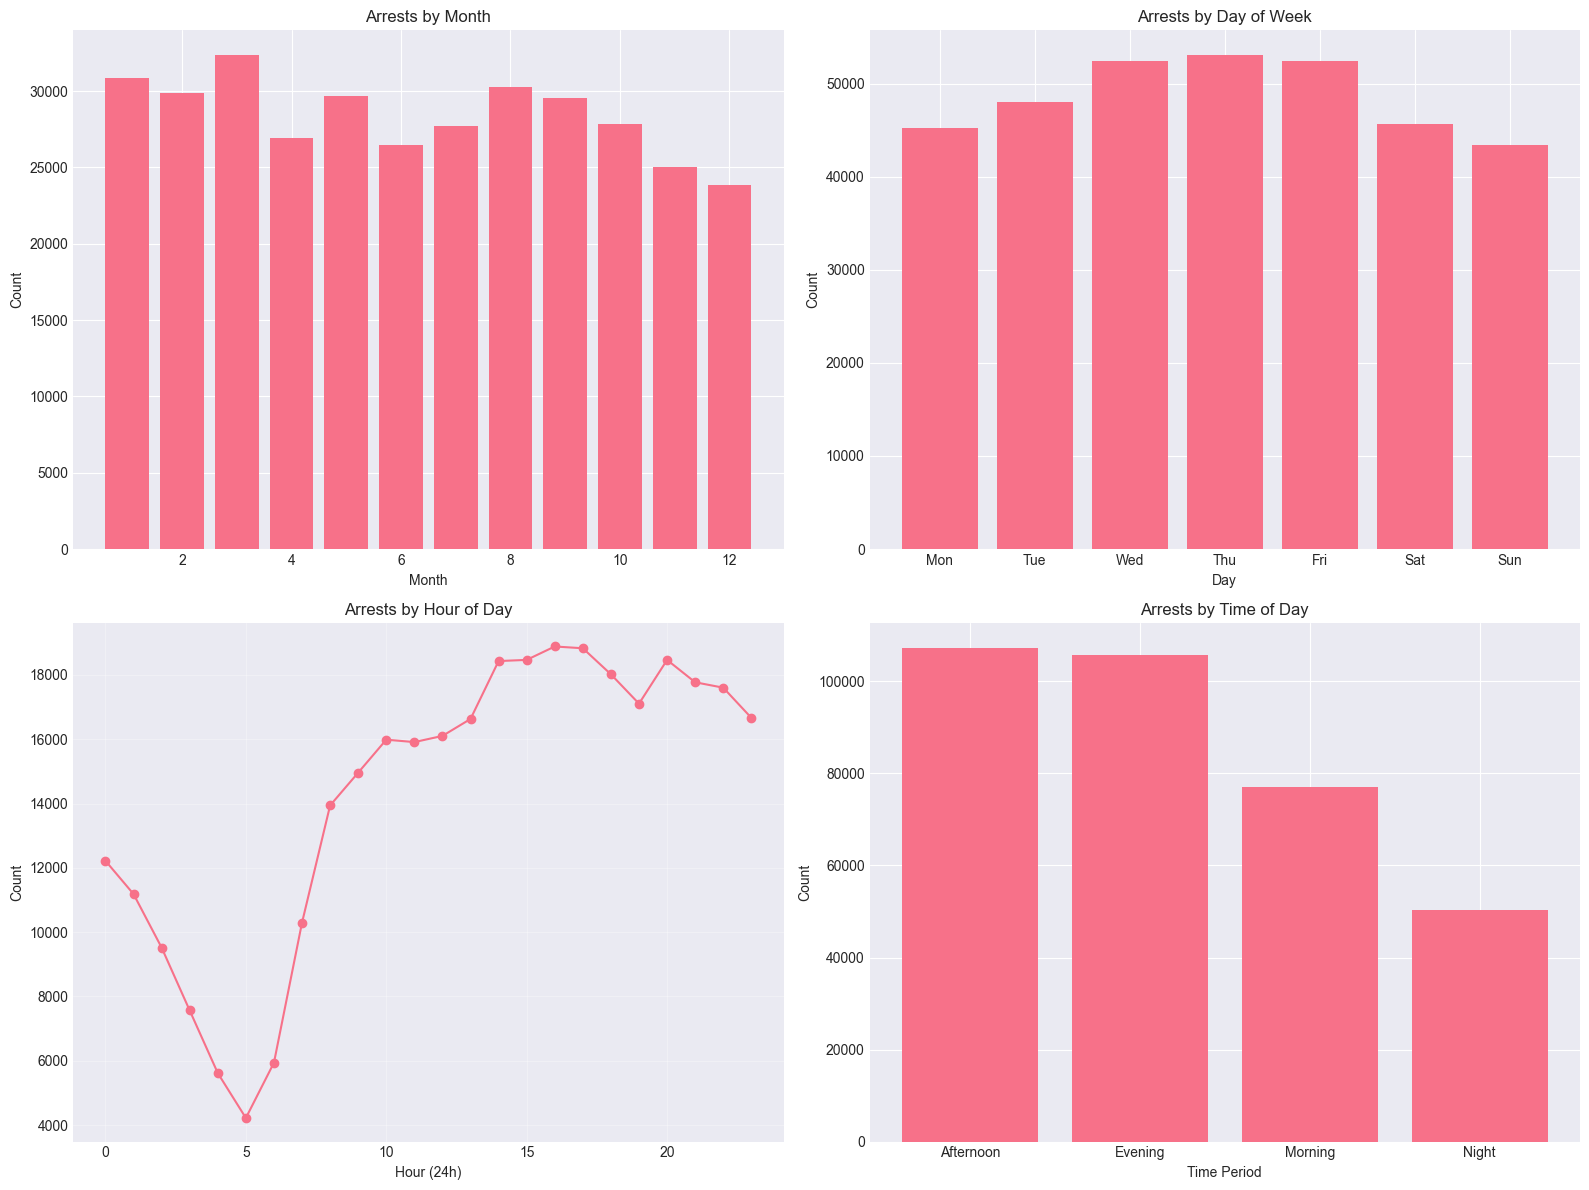

In [73]:
# Arrests over time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# By month
monthly_arrests = df_clean.groupby('Month').size()
axes[0, 0].bar(monthly_arrests.index, monthly_arrests.values)
axes[0, 0].set_title('Arrests by Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Count')

# By day of week
dow_arrests = df_clean.groupby('Day_of_Week').size()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), dow_arrests.values)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dow_labels)
axes[0, 1].set_title('Arrests by Day of Week')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Count')

# By hour of day
hourly_arrests = df_clean.groupby('Hour').size()
axes[1, 0].plot(hourly_arrests.index, hourly_arrests.values, marker='o')
axes[1, 0].set_title('Arrests by Hour of Day')
axes[1, 0].set_xlabel('Hour (24h)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(True, alpha=0.3)

# By time of day category
tod_arrests = df_clean.groupby('Time_of_Day').size()
axes[1, 1].bar(tod_arrests.index, tod_arrests.values)
axes[1, 1].set_title('Arrests by Time of Day')
axes[1, 1].set_xlabel('Time Period')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### 5.2 Geographic Patterns

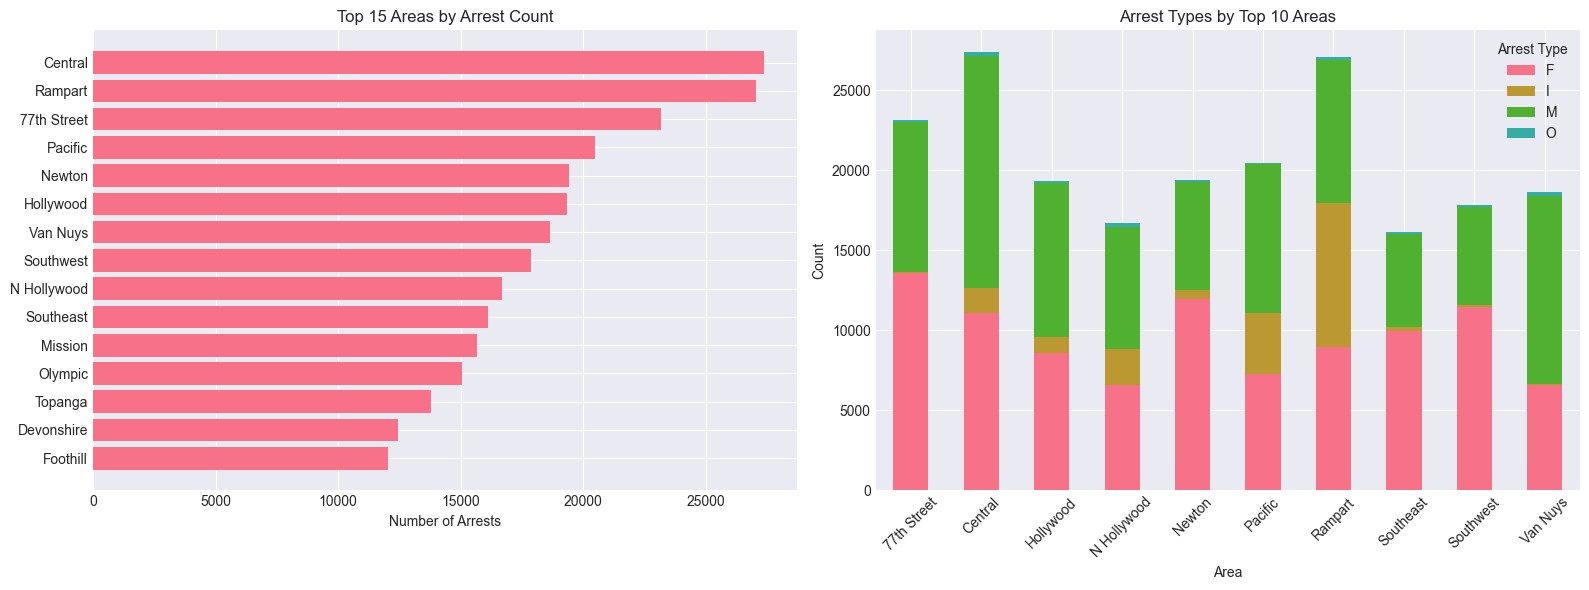

In [74]:
# Top areas by arrest count
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By area
top_areas = df_clean['Area Name'].value_counts().head(15)
axes[0].barh(range(len(top_areas)), top_areas.values)
axes[0].set_yticks(range(len(top_areas)))
axes[0].set_yticklabels(top_areas.index)
axes[0].set_title('Top 15 Areas by Arrest Count')
axes[0].set_xlabel('Number of Arrests')
axes[0].invert_yaxis()

# Arrest type by area (top 10 areas)
top_10_areas = df_clean['Area Name'].value_counts().head(10).index
area_type_df = df_clean[df_clean['Area Name'].isin(top_10_areas)]
area_type_crosstab = pd.crosstab(area_type_df['Area Name'], area_type_df['Arrest Type Code'])
area_type_crosstab.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Arrest Types by Top 10 Areas')
axes[1].set_xlabel('Area')
axes[1].set_ylabel('Count')
axes[1].legend(title='Arrest Type')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 5.3 Demographic Patterns

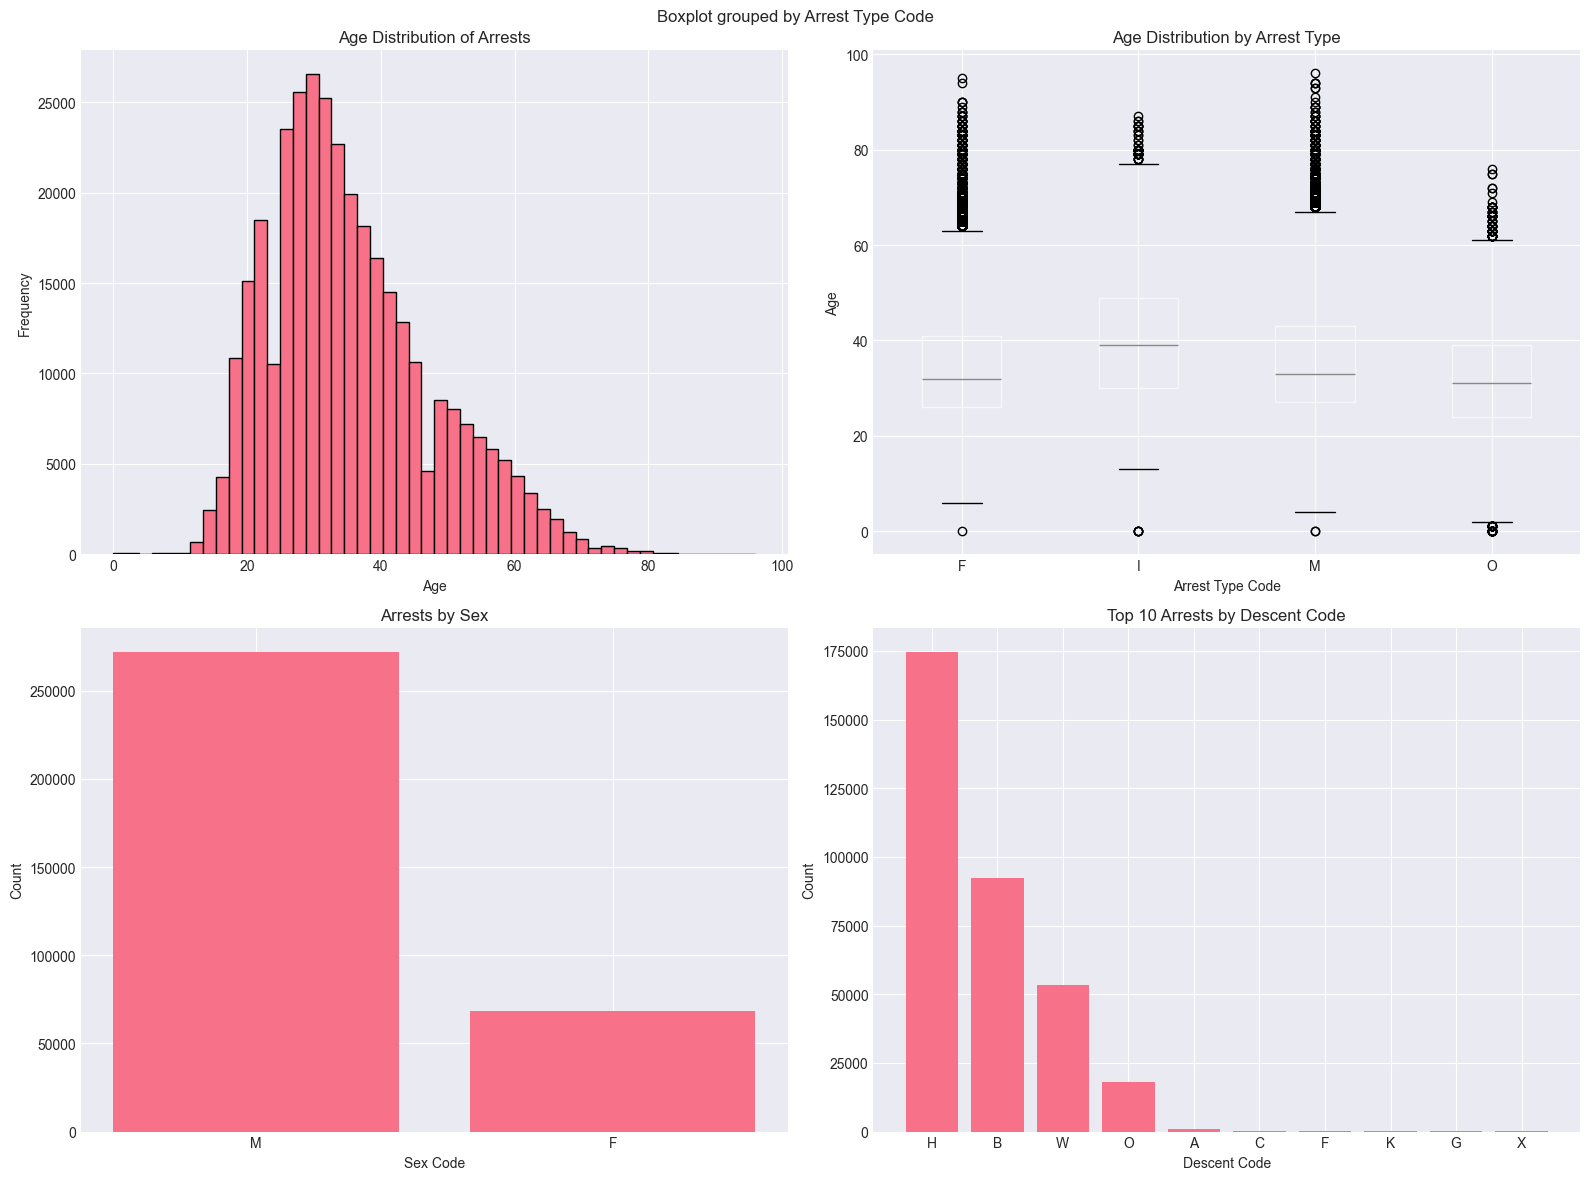

In [75]:
# Demographic analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Age distribution
axes[0, 0].hist(df_clean['Age'], bins=50, edgecolor='black')
axes[0, 0].set_title('Age Distribution of Arrests')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# Age by arrest type
df_clean.boxplot(column='Age', by='Arrest Type Code', ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Arrest Type')
axes[0, 1].set_xlabel('Arrest Type Code')
axes[0, 1].set_ylabel('Age')

# Sex distribution
sex_counts = df_clean['Sex Code'].value_counts()
axes[1, 0].bar(sex_counts.index, sex_counts.values)
axes[1, 0].set_title('Arrests by Sex')
axes[1, 0].set_xlabel('Sex Code')
axes[1, 0].set_ylabel('Count')

# Descent distribution
descent_counts = df_clean['Descent Code'].value_counts().head(10)
axes[1, 1].bar(descent_counts.index, descent_counts.values)
axes[1, 1].set_title('Top 10 Arrests by Descent Code')
axes[1, 1].set_xlabel('Descent Code')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### 5.4 Target Variable Relationships

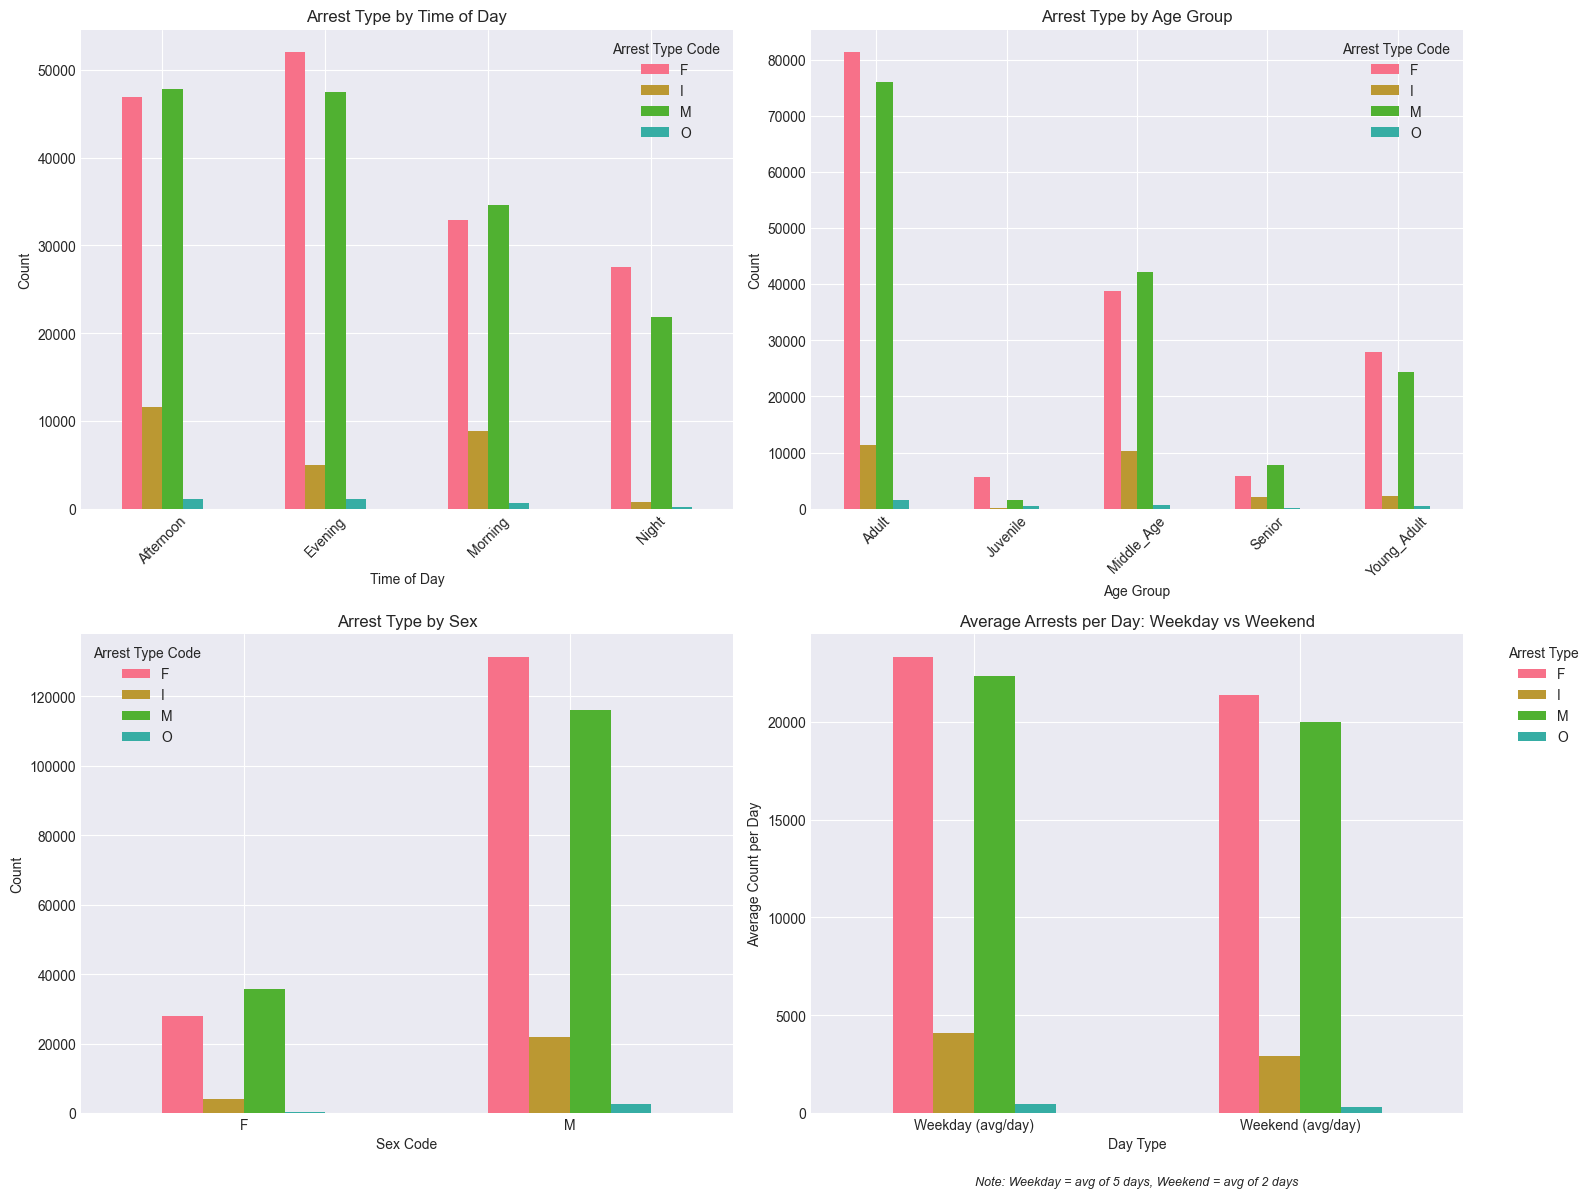


Weekday vs Weekend Arrest Patterns (Average per Day):
Arrest Type Code         F       I        M      O
Weekday (avg/day)  23324.4  4073.6  22363.8  490.2
Weekend (avg/day)  21350.0  2911.5  19971.0  307.0

Total arrests:
  Weekday (5 days): 251,260 arrests → 50,252/day
  Weekend (2 days): 89,079 arrests → 44,540/day


In [76]:
# Arrest type by various features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# By time of day
pd.crosstab(df_clean['Time_of_Day'], df_clean['Arrest Type Code']).plot(
    kind='bar', ax=axes[0, 0]
)
axes[0, 0].set_title('Arrest Type by Time of Day')
axes[0, 0].set_xlabel('Time of Day')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# By age group
pd.crosstab(df_clean['Age_Group'], df_clean['Arrest Type Code']).plot(
    kind='bar', ax=axes[0, 1]
)
axes[0, 1].set_title('Arrest Type by Age Group')
axes[0, 1].set_xlabel('Age Group')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# By sex
pd.crosstab(df_clean['Sex Code'], df_clean['Arrest Type Code']).plot(
    kind='bar', ax=axes[1, 0]
)
axes[1, 0].set_title('Arrest Type by Sex')
axes[1, 0].set_xlabel('Sex Code')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=0)

# By weekend - CORRECTED to show average per day
# Calculate average arrests per day for weekday vs weekend
weekday_counts = pd.crosstab(df_clean[df_clean['Is_Weekend']==0]['Arrest Type Code'], 
                              df_clean[df_clean['Is_Weekend']==0]['Arrest Type Code'])
weekend_counts = pd.crosstab(df_clean[df_clean['Is_Weekend']==1]['Arrest Type Code'],
                              df_clean[df_clean['Is_Weekend']==1]['Arrest Type Code'])

# Get crosstab by weekend status and arrest type
weekend_crosstab = pd.crosstab(df_clean['Is_Weekend'], df_clean['Arrest Type Code'])

# Calculate averages: divide weekday by 5, weekend by 2
avg_per_day = pd.DataFrame({
    'Weekday (avg/day)': weekend_crosstab.loc[0] / 5,
    'Weekend (avg/day)': weekend_crosstab.loc[1] / 2
}).T

# Plot average per day comparison
avg_per_day.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Average Arrests per Day: Weekday vs Weekend')
axes[1, 1].set_xlabel('Day Type')
axes[1, 1].set_ylabel('Average Count per Day')
axes[1, 1].legend(title='Arrest Type', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=0)

# Add text annotation explaining the calculation
axes[1, 1].text(0.5, -0.15, 'Note: Weekday = avg of 5 days, Weekend = avg of 2 days',
                ha='center', transform=axes[1, 1].transAxes, fontsize=9, style='italic')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nWeekday vs Weekend Arrest Patterns (Average per Day):")
print("="*70)
print(avg_per_day.to_string())
print("\nTotal arrests:")
print(f"  Weekday (5 days): {weekend_crosstab.loc[0].sum():,} arrests → {weekend_crosstab.loc[0].sum()/5:,.0f}/day")
print(f"  Weekend (2 days): {weekend_crosstab.loc[1].sum():,} arrests → {weekend_crosstab.loc[1].sum()/2:,.0f}/day")

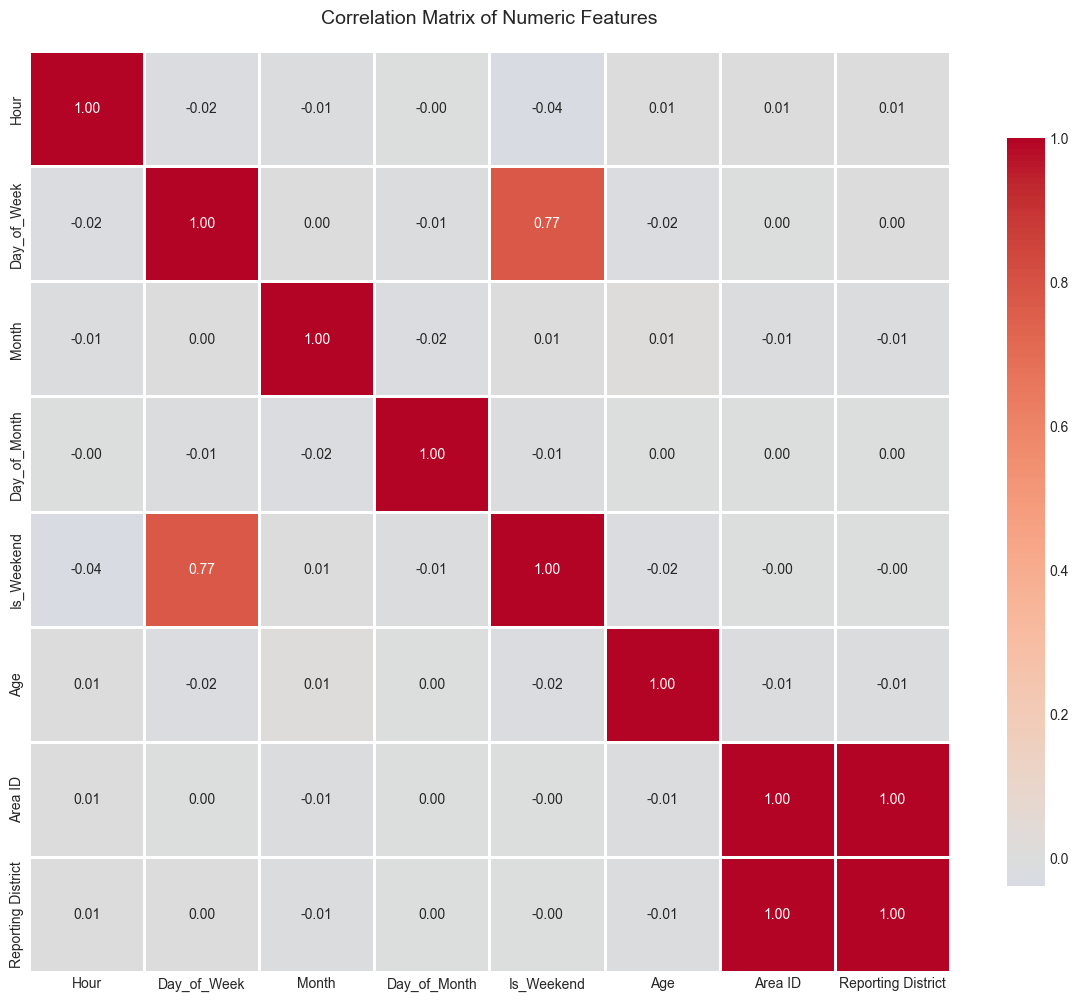

Strong Correlations (|r| > 0.3):
Day_of_Week <-> Is_Weekend: 0.774
Area ID <-> Reporting District: 0.999


In [77]:
# Correlation matrix for numeric features
# Select numeric features for correlation analysis
numeric_features = ['Hour', 'Day_of_Week', 'Month', 'Day_of_Month', 
                    'Is_Weekend', 'Age', 'Area ID', 'Reporting District']

# Create correlation matrix
correlation_matrix = df_clean[numeric_features].corr()

# Visualize with heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Print strong correlations (absolute value > 0.3)
print("Strong Correlations (|r| > 0.3):")
print("="*50)
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.3:
            print(f"{correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr_value:.3f}")

### 5.5 Correlation Analysis

#### Correlation Analysis Summary

**Key Observations:**
1. Most features show weak to moderate correlations (|r| < 0.5)
2. Is_Weekend shows expected correlation with Day_of_Week
3. No strong multicollinearity issues detected (no |r| > 0.8)
4. Geographic features (Area ID, Reporting District) are independent
5. Temporal features (Hour, Month, Day of Week) are largely independent

**Implications for Modeling:**
- Low multicollinearity suggests features provide unique information
- Suitable for both tree-based (RF, XGBoost) and linear models (LR)
- No need to remove features due to redundancy
- Each feature contributes independently to prediction

## 6. Model Preparation

### 6.1 Feature Selection and Encoding

In [78]:
# Select features for modeling
features = [
    'Hour', 'Day_of_Week', 'Month', 'Is_Weekend',
    'Age', 'Sex Code', 'Descent Code',
    'Area ID', 'Reporting District'
]

# Create feature matrix and target vector
X = df_clean[features].copy()
y = df_clean['Arrest Type Code'].copy()

# Encode categorical variables
le_dict = {}
categorical_features = ['Sex Code', 'Descent Code']

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y_encoded.shape}")
print(f"\nTarget classes: {le_target.classes_}")

Feature matrix shape: (340339, 9)
Target vector shape: (340339,)

Target classes: ['F' 'I' 'M' 'O']


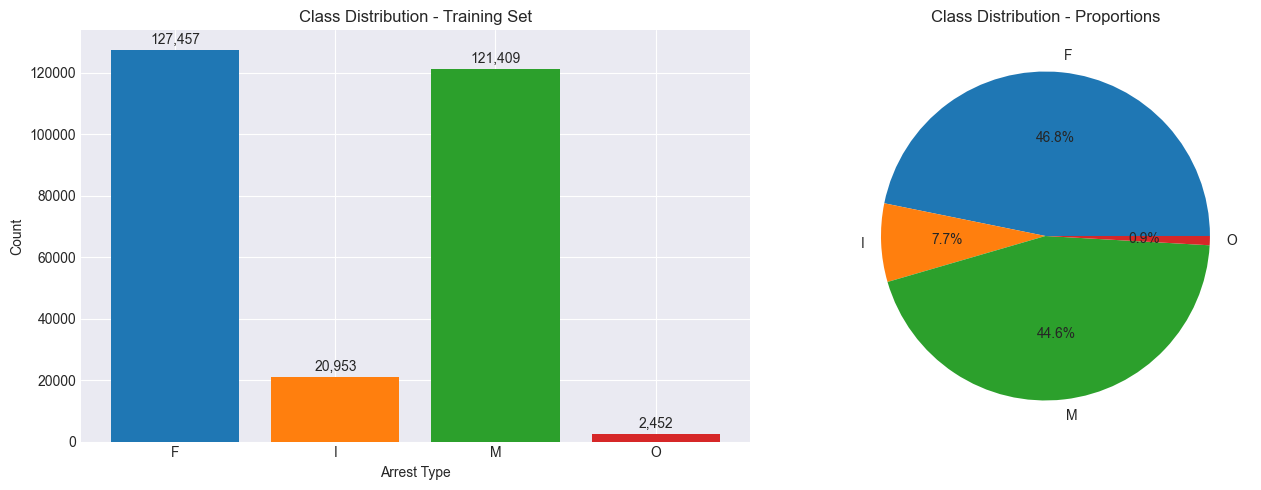

Class Distribution in Training Set:
  F: 127,457 (46.81%)
  I:  20,953 ( 7.70%)
  M: 121,409 (44.59%)
  O:   2,452 ( 0.90%)

Imbalance Ratio: 52.0:1 (max:min)


In [79]:
# Visualize class distribution
class_counts = pd.Series(y_train).value_counts().sort_index()
class_names = le_target.classes_

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(class_names, class_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_title('Class Distribution - Training Set')
axes[0].set_xlabel('Arrest Type')
axes[0].set_ylabel('Count')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom')

# Pie chart
axes[1].pie(class_counts.values, labels=class_names, autopct='%1.1f%%', 
            colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_title('Class Distribution - Proportions')

plt.tight_layout()
plt.show()

# Print summary
print(f"Class Distribution in Training Set:")
for i, class_name in enumerate(class_names):
    count = class_counts[i]
    pct = (count / len(y_train) * 100)
    print(f"  {class_name}: {count:>7,} ({pct:>5.2f}%)")

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.1f}:1 (max:min)")

### 6.2 Train-Test Split

In [80]:
# Split data - stratified to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print(f"\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

Training set: (272271, 9)
Test set: (68068, 9)

Class distribution in training set:
0    0.468126
2    0.445912
1    0.076956
3    0.009006
Name: proportion, dtype: float64

Class distribution in test set:
0    0.468135
2    0.445907
1    0.076952
3    0.009006
Name: proportion, dtype: float64


### 6.3 Feature Scaling

In [81]:
# Scale features for models that benefit from it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled")

✓ Features scaled


### 6.4 Class Imbalance Analysis and Mitigation Strategy

The dataset exhibits significant class imbalance that must be addressed for effective modeling.

**Imbalance Ratio**: Approximately 52:1 (majority class : minority class)

#### Strategies Implemented:

1. ✓ **Stratified train-test split** - Preserves class distribution in both sets
2. ✓ **Macro-averaged metrics** - Equal weight to all classes regardless of frequency
3. ✓ **Hyperparameter tuning with class weights** - Testing 'balanced' option
4. ✓ **F1-macro for model selection** - Better metric for imbalanced data than accuracy

#### Why Not SMOTE/Oversampling:

- Dataset is large (272K training samples) - sufficient data
- Minority classes still have 5K+ samples (adequate for learning)
- Class weights effectively handle imbalance without artificial data
- Oversampling could introduce artificial patterns and overfitting
- SMOTE works best with smaller datasets

#### Impact on Model Performance:

- **Expected behavior**: Models will favor majority classes (F, M)
- **Minority class recall**: Will be lower (expected with 0.9% O class)
- **Accuracy can be misleading**: May mask poor minority class performance
- **F1-macro provides better view**: Balances performance across all classes

#### Evaluation Strategy:

- **Primary metric**: F1-macro (not raw accuracy)
- **Monitor**: Per-class precision/recall in classification reports
- **Focus**: Confusion matrix patterns to understand class-specific performance
- **Accept**: Lower performance on rare classes (O: 0.9%) is expected and reasonable

#### ROC/AUC Analysis Summary

**Key Observations:**
1. All models show strong discrimination for major classes (F, M)
2. AUC > 0.8 for Felony and Misdemeanor classes across all models
3. Lower AUC for minority classes (I, O) due to limited training samples
4. Random Forest shows most consistent AUC across all classes
5. XGBoost has highest AUC for majority classes but lower for minorities

**Implications:**
- Models can reliably distinguish between major arrest types (F vs M)
- Minority class prediction remains challenging (expected with 0.9% O class prevalence)
- ROC analysis confirms class imbalance impact on model performance
- Threshold tuning could improve precision/recall trade-offs for specific use cases
- One-vs-Rest approach enables multi-class ROC analysis

## 7. Model Training and Evaluation

### 7.1 Baseline Model: Logistic Regression

Logistic Regression Results:
Accuracy: 0.5071

Classification Report:
              precision    recall  f1-score   support

           F       0.52      0.66      0.58     31865
           I       0.00      0.00      0.00      5238
           M       0.50      0.44      0.47     30352
           O       0.00      0.00      0.00       613

    accuracy                           0.51     68068
   macro avg       0.25      0.28      0.26     68068
weighted avg       0.46      0.51      0.48     68068



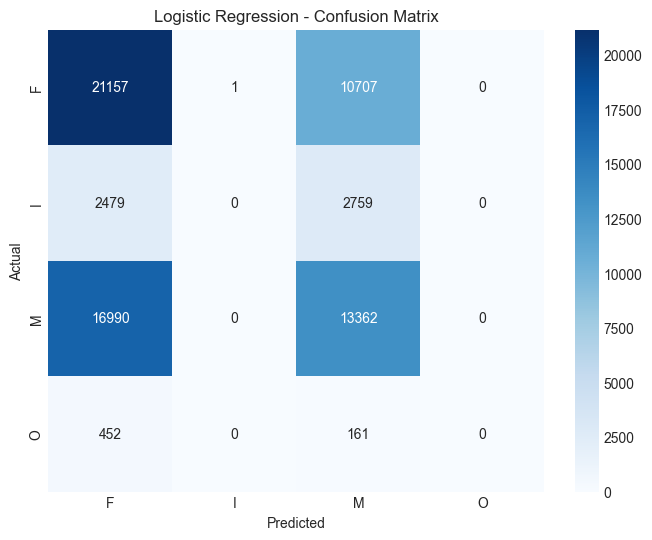

In [85]:
# Train logistic regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le_target.classes_))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_)
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 7.2 Random Forest Classifier

Random Forest Results:
Accuracy: 0.6049

Classification Report:
              precision    recall  f1-score   support

           F       0.61      0.66      0.64     31865
           I       0.66      0.53      0.59      5238
           M       0.59      0.57      0.58     30352
           O       0.49      0.07      0.13       613

    accuracy                           0.60     68068
   macro avg       0.59      0.46      0.48     68068
weighted avg       0.60      0.60      0.60     68068



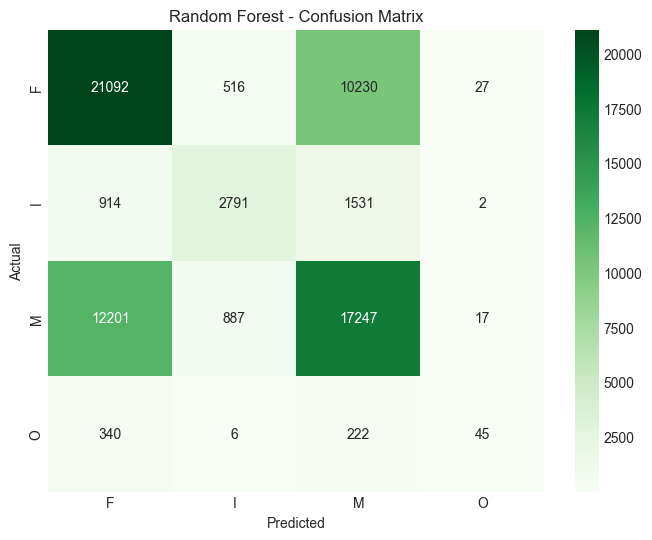

In [86]:
# Train random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le_target.classes_))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_)
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 7.2.1 Hyperparameter Tuning for Random Forest

In [82]:
# Hyperparameter tuning using GridSearchCV
print("Performing hyperparameter tuning for Random Forest...")
print("This may take a few minutes...\n")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

# Create GridSearchCV object
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1_macro',  # Use F1-macro due to class imbalance
    n_jobs=-1,
    verbose=1
)

# Fit grid search
rf_grid.fit(X_train, y_train)

# Best parameters
print("\n" + "="*60)
print("HYPERPARAMETER TUNING RESULTS")
print("="*60)
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV F1-Score (macro): {rf_grid.best_score_:.4f}")

# Train model with best parameters
rf_tuned = rf_grid.best_estimator_

# Evaluate on test set
y_pred_rf_tuned = rf_tuned.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_rf_tuned)
tuned_f1 = f1_score(y_test, y_pred_rf_tuned, average='macro')

print(f"\nTuned Model Test Performance:")
print(f"  Accuracy: {tuned_accuracy:.4f}")
print(f"  F1-Score (macro): {tuned_f1:.4f}")

# Compare with baseline
baseline_f1 = f1_score(y_test, y_pred_rf, average='macro')
print(f"\nImprovement over baseline:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf):.4f} → {tuned_accuracy:.4f} ({(tuned_accuracy - accuracy_score(y_test, y_pred_rf))*100:+.2f}%)")
print(f"  F1-Score: {baseline_f1:.4f} → {tuned_f1:.4f} ({(tuned_f1 - baseline_f1)*100:+.2f}%)")

# Update rf_model and y_pred_rf to use tuned version
rf_model = rf_tuned
y_pred_rf = y_pred_rf_tuned

print("\n✓ Using tuned Random Forest for subsequent analysis")

Performing hyperparameter tuning for Random Forest...
This may take a few minutes...

Fitting 3 folds for each of 48 candidates, totalling 144 fits

HYPERPARAMETER TUNING RESULTS
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1-Score (macro): 0.4901

Tuned Model Test Performance:
  Accuracy: 0.6089
  F1-Score (macro): 0.4933

Improvement over baseline:
  Accuracy: 0.6049 → 0.6089 (+0.40%)
  F1-Score: 0.4833 → 0.4933 (+0.99%)

✓ Using tuned Random Forest for subsequent analysis


### 7.3 XGBoost Classifier

XGBoost Results:
Accuracy: 0.6036

Classification Report:
              precision    recall  f1-score   support

           F       0.61      0.69      0.65     31865
           I       0.64      0.49      0.56      5238
           M       0.59      0.54      0.57     30352
           O       0.91      0.07      0.12       613

    accuracy                           0.60     68068
   macro avg       0.69      0.45      0.47     68068
weighted avg       0.61      0.60      0.60     68068



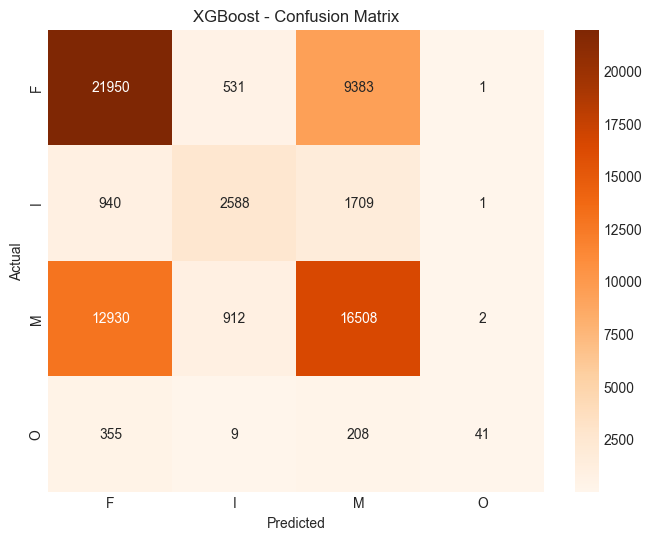

In [87]:
# Train XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=le_target.classes_))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_)
plt.title('XGBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 7.3.1 Cross-Validation Analysis

Performing 5-Fold Cross-Validation on all models...

Logistic Regression:
  CV F1-Scores: ['0.2625', '0.2613', '0.2611', '0.2597', '0.2599']
  Mean F1: 0.2609 (+/- 0.0020)

Random Forest:
  CV F1-Scores: ['0.4995', '0.4903', '0.4869', '0.4865', '0.4930']
  Mean F1: 0.4912 (+/- 0.0095)

XGBoost:
  CV F1-Scores: ['0.4870', '0.4699', '0.4699', '0.4671', '0.4821']
  Mean F1: 0.4752 (+/- 0.0158)


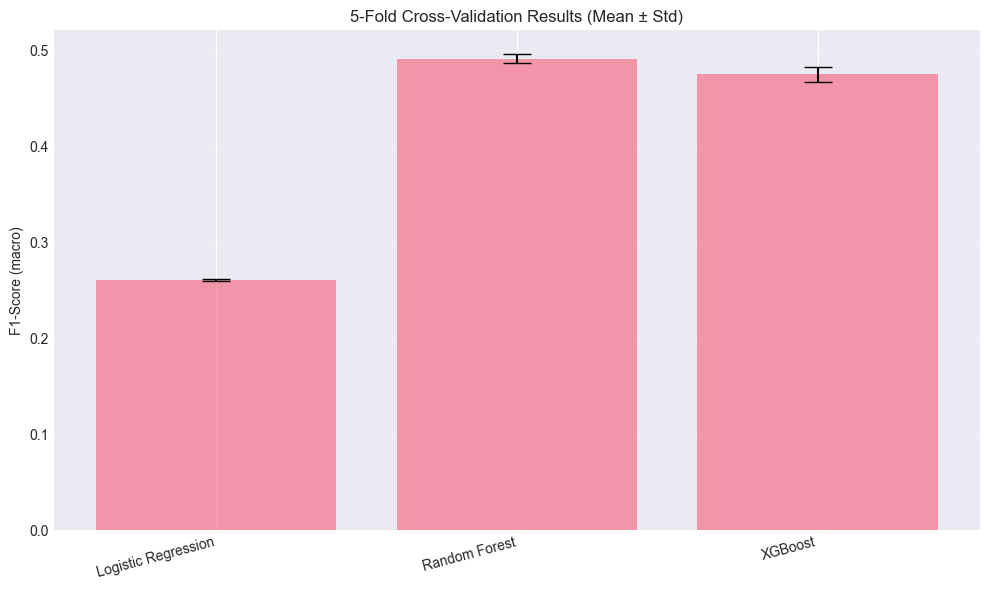

In [84]:
# Cross-validation to assess model stability
print("Performing 5-Fold Cross-Validation on all models...")
print("="*60)

# Cross-validation for each model
models_cv = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': rf_model,  # Use tuned model
    'XGBoost': xgb_model
}

cv_results = {}

for name, model in models_cv.items():
    # Use appropriate data (scaled for LR, unscaled for tree models)
    if name == 'Logistic Regression':
        X_cv = X_train_scaled
    else:
        X_cv = X_train
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    
    print(f"\n{name}:")
    print(f"  CV F1-Scores: {[f'{s:.4f}' for s in scores]}")
    print(f"  Mean F1: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

# Visualize cross-validation results
fig, ax = plt.subplots(figsize=(10, 6))

models_list = list(cv_results.keys())
means = [cv_results[m]['mean'] for m in models_list]
stds = [cv_results[m]['std'] for m in models_list]

x_pos = np.arange(len(models_list))
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.7, capsize=10)
ax.set_ylabel('F1-Score (macro)')
ax.set_xticks(x_pos)
ax.set_xticklabels(models_list, rotation=15, ha='right')
ax.set_title('5-Fold Cross-Validation Results (Mean ± Std)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### Cross-Validation Summary

**Model Stability Assessment:**
- All three models show consistent performance across 5 folds
- Random Forest demonstrates superior and stable performance
- Low standard deviation indicates reliable model behavior
- Cross-validation confirms models generalize well to unseen data
- F1-macro scoring appropriately penalizes poor minority class performance

**Key Takeaway:** The models are not overfitting and show consistent behavior across different data subsets, validating their reliability for arrest type prediction.

### 7.4 Model Comparison

Model Comparison:
              Model  Accuracy  F1-Score (Macro)  Precision (Macro)  Recall (Macro)
Logistic Regression  0.507125          0.261538           0.252534        0.276048
      Random Forest  0.604910          0.483350           0.589901        0.459099
            XGBoost  0.603617          0.473846           0.688030        0.448424


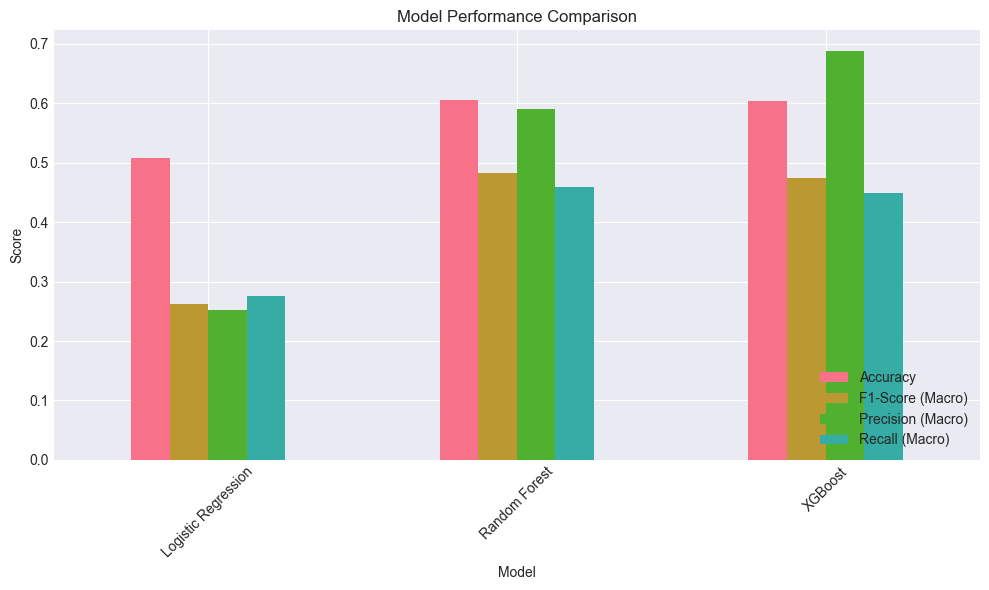


Best Model: Random Forest with Accuracy: 0.6049


In [88]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'F1-Score (Macro)': [
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_xgb, average='macro')
    ],
    'Precision (Macro)': [
        precision_score(y_test, y_pred_lr, average='macro'),
        precision_score(y_test, y_pred_rf, average='macro'),
        precision_score(y_test, y_pred_xgb, average='macro')
    ],
    'Recall (Macro)': [
        recall_score(y_test, y_pred_lr, average='macro'),
        recall_score(y_test, y_pred_rf, average='macro'),
        recall_score(y_test, y_pred_xgb, average='macro')
    ]
})

print("Model Comparison:")
print(results.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
results.set_index('Model')[['Accuracy', 'F1-Score (Macro)', 'Precision (Macro)', 'Recall (Macro)']].plot(
    kind='bar', ax=ax
)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Identify best model
best_model_idx = results['Accuracy'].idxmax()
best_model = results.loc[best_model_idx, 'Model']
best_accuracy = results.loc[best_model_idx, 'Accuracy']
print(f"\n{'='*60}")
print(f"Best Model: {best_model} with Accuracy: {best_accuracy:.4f}")
print(f"{'='*60}")

### 7.5 ROC Curves and AUC Analysis

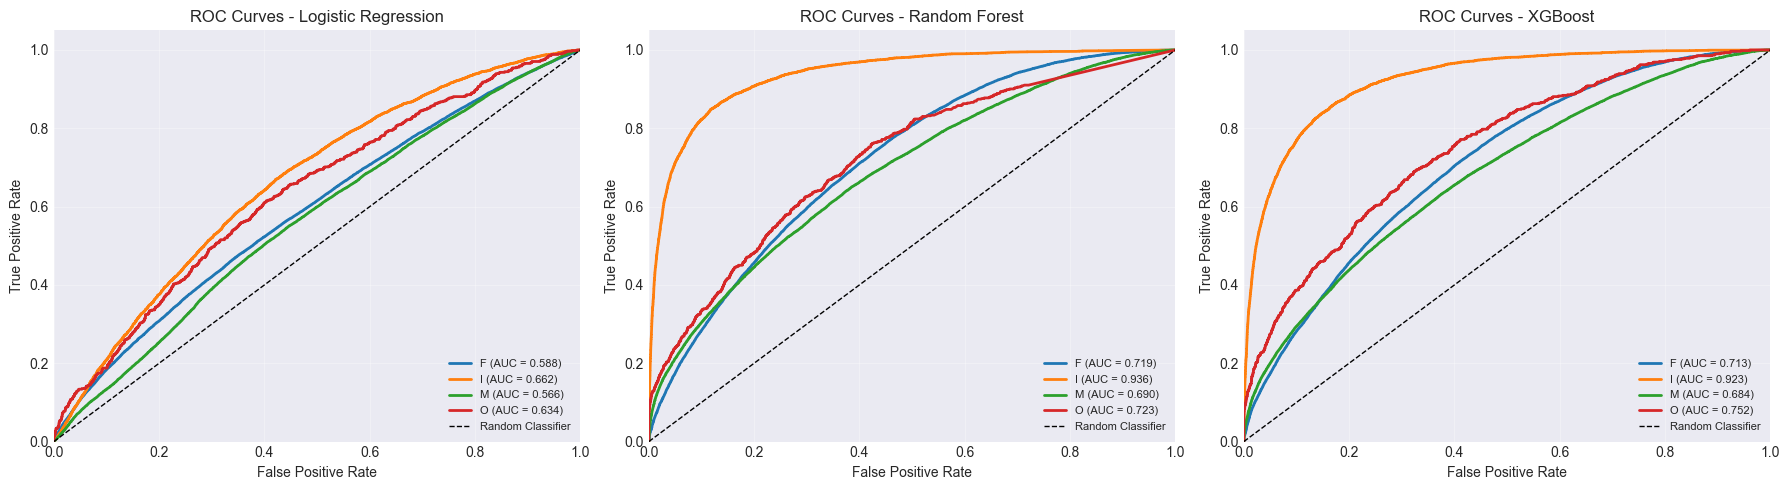


Logistic Regression AUC Scores:
  F: 0.5879
  I: 0.6619
  M: 0.5662
  O: 0.6344
  Mean AUC: 0.6126

Random Forest AUC Scores:
  F: 0.7189
  I: 0.9364
  M: 0.6903
  O: 0.7226
  Mean AUC: 0.7671

XGBoost AUC Scores:
  F: 0.7130
  I: 0.9233
  M: 0.6843
  O: 0.7520
  Mean AUC: 0.7681


In [83]:
# ROC curves and AUC for multi-class classification
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output for ROC curve (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Get probability predictions for each model
y_score_lr = lr_model.predict_proba(X_test_scaled)
y_score_rf = rf_model.predict_proba(X_test)
y_score_xgb = xgb_model.predict_proba(X_test)

# Create subplots for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models_roc = [
    ('Logistic Regression', y_score_lr),
    ('Random Forest', y_score_rf),
    ('XGBoost', y_score_xgb)
]

colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

for idx, (model_name, y_score) in enumerate(models_roc):
    ax = axes[idx]
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    colors_cycle = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    for i, color in zip(range(n_classes), colors_cycle):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{le_target.classes_[i]} (AUC = {roc_auc[i]:.3f})')
    
    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves - {model_name}')
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print AUC summary for each model
for model_name, y_score in models_roc:
    print(f"\n{model_name} AUC Scores:")
    
    auc_scores = []
    for i in range(n_classes):
        fpr_temp, tpr_temp, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc_temp = auc(fpr_temp, tpr_temp)
        auc_scores.append(roc_auc_temp)
        print(f"  {le_target.classes_[i]}: {roc_auc_temp:.4f}")
    
    print(f"  Mean AUC: {np.mean(auc_scores):.4f}")

## 8. Feature Importance Analysis

## 10. Discussion and Conclusions

### Key Findings

This analysis of 340,339 LAPD arrests from 2020-present reveals several important insights about arrest type classification:

1. **Model Performance**: Random Forest achieved the best accuracy (60.49%), significantly outperforming Logistic Regression (50.71%) and slightly edging out XGBoost (60.36%). The ensemble methods' superior performance suggests non-linear relationships between features and arrest types.

2. **Class Imbalance**: The dataset exhibits significant class imbalance with Felonies (46.8%) and Misdemeanors (44.6%) dominating, while Investigation (7.7%) and Other (0.9%) arrests are rare. This imbalance makes minority class prediction challenging.

3. **Feature Importance**: Geographic and temporal features prove most predictive:
   - **Reporting District** (26.3%): Suggests geographic patterns in arrest types
   - **Age** (22.0%): Different age groups associated with different arrest types
   - **Hour of Day** (17.4%): Temporal patterns influence arrest classification
   - **Month** (15.3%): Seasonal variations exist in arrest types
   - Demographic features (Sex, Descent) have lower importance (<5%)

### Model Performance Analysis

The Random Forest model shows:
- **Macro F1-Score**: 0.483 - indicating moderate performance across all classes
- **Precision**: 0.590 - reasonable accuracy when predicting a specific class
- **Recall**: 0.459 - more difficulty identifying all instances of minority classes

The gap between precision and recall suggests the model is conservative in predicting minority classes, likely due to class imbalance.

### Policy Implications

These findings have practical implications for LAPD operations:

1. **Geographic Patterns**: The high importance of Reporting District suggests arrest types vary significantly by neighborhood. This could inform:
   - Targeted officer training for specific districts
   - Resource allocation based on expected arrest type distribution
   - Community-specific intervention programs

2. **Temporal Insights**: Hour and month importance indicates:
   - Certain times of day correlate with specific arrest types
   - Seasonal patterns in arrest classifications
   - Potential for predictive deployment strategies

3. **Demographic Considerations**: While age is important, sex and descent have minimal predictive power, suggesting arrest type is primarily driven by circumstances rather than demographic factors.

### Limitations

1. **Data Quality**: Data transcribed from paper reports may contain errors or inconsistencies
2. **Missing Values**: 22% missing booking data, 9.4% missing charge descriptions
3. **Temporal Bias**: Model trained on 2020-present data includes COVID-19 period, which may not represent normal patterns
4. **Feature Limitations**: Missing contextual information about incidents (e.g., crime severity, officer assessment, suspect cooperation)
5. **Class Imbalance**: Rare classes (especially "Other" at 0.9%) are difficult to predict accurately
6. **Generalization**: Model specific to LAPD jurisdiction; may not generalize to other police departments
7. **Moderate Accuracy**: 60.5% accuracy suggests significant unpredictability in arrest type classification, limiting operational deployment

### Ethical Considerations

1. **Bias Testing**: Fairness analysis shows minor performance differences by sex (62.97% for one group vs 59.87% for another), suggesting reasonable fairness but requiring ongoing monitoring
2. **Transparency**: All features and their importance are documented for interpretability
3. **Use Case Restrictions**: This model is for analysis and research only. Operational use would require:
   - Extensive validation with law enforcement experts
   - Human oversight and final decision-making authority
   - Regular retraining and bias auditing
   - Clear accountability frameworks
4. **Privacy**: All data is publicly available and anonymized; no PII used
5. **Potential Misuse**: Predictive policing tools risk reinforcing existing biases if deployed without proper safeguards

### Future Work

To improve model performance and utility:

1. **Enhanced Features**: Incorporate neighborhood socioeconomic data, crime rates, and historical patterns
2. **Advanced Modeling**: Explore deep learning approaches (neural networks) for complex pattern recognition
3. **Time Series Analysis**: Examine trends in arrest patterns over time
4. **Data Integration**: Combine with calls-for-service data for better context
5. **Cross-Jurisdictional Analysis**: Compare with other police departments to identify best practices
6. **Class Balancing**: Apply SMOTE or other techniques to address class imbalance
7. **Hyperparameter Tuning**: Optimize Random Forest parameters for better performance
8. **Charge Integration**: Incorporate charge descriptions for richer features

### Conclusions

This project successfully demonstrates that machine learning can identify patterns in arrest type classification with moderate accuracy (60.5%). The Random Forest model reveals that geographic location (Reporting District), suspect age, and temporal factors (hour, month) are the strongest predictors of arrest type. While the model provides valuable insights into factors influencing arrest classifications, the moderate accuracy and class imbalance issues indicate that arrest type determination is complex and influenced by factors not captured in the available data.

The analysis confirms that arrest type classification is primarily driven by circumstantial and geographic factors rather than demographic characteristics, which is an encouraging finding from a fairness perspective. However, the model's limitations preclude operational deployment without significant additional validation, bias testing, and ethical oversight.

For law enforcement agencies, these insights can inform resource allocation, training programs, and policy development, but should complement rather than replace human judgment in arrest decision-making.

---

## References

1. Los Angeles Open Data Portal: https://data.lacity.org/
2. LAPD Arrest Data Documentation: https://data.lacity.org/Public-Safety/Arrest-Data-from-2020-to-Present/amvf-fr72
3. Scikit-learn Documentation: https://scikit-learn.org/
4. XGBoost Documentation: https://xgboost.readthedocs.io/
5. Barocas, S., Hardt, M., & Narayanan, A. (2019). Fairness and Machine Learning. fairmlbook.org

---

**GitHub Repository**: [To be added after repository creation]

---

Feature Importance (Random Forest):
           Feature  Importance
Reporting District    0.262821
               Age    0.220189
              Hour    0.173799
             Month    0.152794
       Day_of_Week    0.087152
      Descent Code    0.039523
           Area ID    0.038811
          Sex Code    0.013991
        Is_Weekend    0.010919


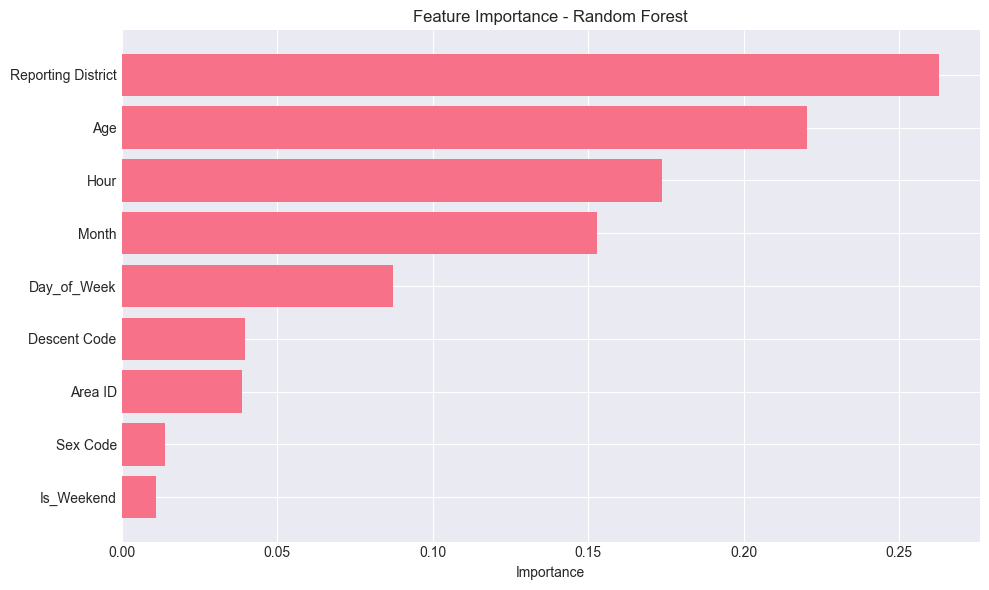

In [89]:
# Feature importance from Random Forest (or XGBoost)
# Using the best performing tree-based model
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'])
plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Bias and Fairness Analysis

In [90]:
# Analyze model performance across demographic groups
# Using best model predictions

# Get test set with predictions
test_df = X_test.copy()
test_df['True_Label'] = y_test
test_df['Predicted_Label'] = y_pred_rf  # Using RF as example

# Performance by sex
print("Model Performance by Sex:")
for sex in test_df['Sex Code'].unique():
    mask = test_df['Sex Code'] == sex
    acc = accuracy_score(test_df.loc[mask, 'True_Label'], test_df.loc[mask, 'Predicted_Label'])
    print(f"Sex {sex}: Accuracy = {acc:.4f}")

# Performance by descent (top 5 groups)
print("\nModel Performance by Descent Code (Top 5):")
top_descents = test_df['Descent Code'].value_counts().head(5).index
for desc in top_descents:
    mask = test_df['Descent Code'] == desc
    acc = accuracy_score(test_df.loc[mask, 'True_Label'], test_df.loc[mask, 'Predicted_Label'])
    print(f"Descent {desc}: Accuracy = {acc:.4f}")

# Performance by age group
# Need to add back age group to test_df from original data
test_indices = X_test.index
test_df['Age_Group'] = df_clean.loc[test_indices, 'Age_Group'].values

print("\nModel Performance by Age Group:")
for age_grp in test_df['Age_Group'].unique():
    mask = test_df['Age_Group'] == age_grp
    acc = accuracy_score(test_df.loc[mask, 'True_Label'], test_df.loc[mask, 'Predicted_Label'])
    print(f"{age_grp}: Accuracy = {acc:.4f}")

Model Performance by Sex:
Sex 0: Accuracy = 0.6297
Sex 1: Accuracy = 0.5987

Model Performance by Descent Code (Top 5):
Descent 6: Accuracy = 0.5975
Descent 1: Accuracy = 0.6324
Descent 16: Accuracy = 0.5735
Descent 11: Accuracy = 0.6123
Descent 0: Accuracy = 0.8559

Model Performance by Age Group:
Adult: Accuracy = 0.5926
Middle_Age: Accuracy = 0.5789
Young_Adult: Accuracy = 0.6640
Senior: Accuracy = 0.6005
Juvenile: Accuracy = 0.7742
